In [20]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from typing import List, Dict
import matplotlib.pyplot as plt

In [21]:
# генератор метрик
def eval_metrics(y_test: pd.DataFrame, y_pred: pd.DataFrame, verbose: bool) -> List[float]:
    """
    :param y_test: test dataset
    :param y_pred: predicted dataset
    :param verbose: print scores flag
    :return: list of scores [Precision Score, Recall Score, F1 Score, Accuracy Score, ROC AUC]
    """
    pr_sc = round(precision_score(y_val, y_pred), 3)
    re_sc = round(recall_score(y_val, y_pred), 3)
    f1_sc = round(f1_score(y_val, y_pred), 3)
    ac_sc = round(accuracy_score(y_val, y_pred), 3)
    ra_sc = round(roc_auc_score(y_val, y_pred), 3)

    print('Precision Score: ', pr_sc)
    print('Recall Score: ', re_sc)
    print('F1 Score: ', f1_sc)
    print('Accuracy Score: ', ac_sc)
    print('ROC AUC: ', ra_sc)

    return [pr_sc, re_sc, f1_sc, ac_sc, ra_sc]

In [22]:
# предобработчик наборов данных
def load_datasets(X_filename: str, y_filename: str, X_val_filename: str, y_val_filename: str) -> List[pd.DataFrame]:
    """
    :param X_filename: path to csx with X data
    :param y_filename: path to csx with y data
    :param X_val_filename: path to csx with X_val data
    :param y_val_filename: path to csx with y_val data
    :return: list of pandas dataframes [X, y, X_val, y_val]
    """
    X = pd.read_csv(X_filename)
    y = pd.read_csv(y_filename)
    X_val = pd.read_csv(X_val_filename)
    y_val = pd.read_csv(y_val_filename)

    x_col_names = list(X.columns)
    x_col_names[0] = 'user_id'
    X.columns = x_col_names
    X_val.columns = x_col_names
    y = y.drop(columns=[list(y.columns)[0]])
    y_val = y_val.drop(columns=[list(y_val.columns)[0]])

    return [X, y, X_val, y_val]

In [23]:
# визуализация зависимости метрик от гиперпараметра "iterations"
def visualize_it(catboost_scores: pd.DataFrame) -> None:
    """
    :param catboost_scores: dataframe with index = iterations param value,
             metrics columns = ['Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score', 'ROC AUC']
    :return:
    """
    plt.figure(figsize=[15, 10])
    plt.plot(catboost_scores['Precision Score'], label=catboost_scores.columns[0])
    plt.plot(catboost_scores['Recall Score'], label=catboost_scores.columns[1])
    plt.plot(catboost_scores['F1 Score'], label=catboost_scores.columns[2])
    plt.plot(catboost_scores['Accuracy Score'], label=catboost_scores.columns[3])
    plt.plot(catboost_scores['ROC AUC'], label=catboost_scores.columns[4])
    plt.xlabel('Количество итераций (параметр "iterations")')
    plt.ylabel('Значение метрики')
    plt.title('Зависимость метрик качества от гиперпараметра "iterations"')
    plt.legend()
    plt.show()

In [24]:
# непосредственно catboost
def catboost_it(X: pd.DataFrame, y: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame, min_iterations: int,
                max_iterations: int, verbose: bool) -> pd.DataFrame:
    """
    :param X: training set of values
    :param y: training set of results
    :param X_val: test set of values
    :param y_val: test set of results
    :param min_iterations: minimum value of catboost's iterations parameter
    :param max_iterations: max value of catboost's iterations parameter
    :param verbose: is needed to show iteration info
    :return: dataframe with index = iterations param value,
             metrics columns = ['Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score', 'ROC AUC']
    """
    catboost_boost_results = dict()
    for i in range(min_iterations, max_iterations):
        catboost_model = CatBoostClassifier(iterations=i + 1)
        catboost_model.fit(X, y)
        prediction = catboost_model.predict(X_val)
        catboost_boost_results[i + 1] = eval_metrics(y_val, prediction, verbose)

    catboost_scores = pd.DataFrame(catboost_boost_results).T
    catboost_scores.columns = ['Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score', 'ROC AUC']

    return catboost_scores

## Набор данных "Первая итерация"

In [25]:
# загружаем данные
X, y, X_val, y_val = load_datasets('0_X.csv', '0_y.csv', '0_X_val.csv', '0_y_val.csv')

In [26]:
X

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,957056,12.0,18.0,-0.638518,-0.718161,-0.718841,-0.718706,-0.747321,-0.252563,-0.315014,-0.377476,-0.332739,0.000000,0.000000,0.446632,0.000000
1,536962,8.0,24.0,-0.708945,-0.793489,-0.699894,-0.699898,-0.747321,-0.249717,-0.313873,-0.450555,0.000000,0.000000,-0.220128,0.581223,0.000000
2,1575854,0.0,24.0,0.002368,1.541680,0.190890,0.190749,1.702509,0.028720,-0.212311,-0.236189,0.454859,0.000000,0.000000,-0.091734,1.363902
3,1543057,9.0,24.0,0.699596,0.110447,0.698418,0.698556,0.613696,-0.252563,0.355982,-0.338500,-0.316987,-0.208879,0.000000,1.433635,-0.267198
4,1520724,14.0,24.0,-0.596262,-0.416849,-0.586770,-0.586634,-0.407067,-0.186736,-0.273933,-0.401836,-0.316987,0.000000,0.000000,0.715815,-0.593418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723233,73349,14.0,24.0,0.122094,-0.115537,0.206633,0.206631,0.001238,0.017487,-0.315014,-0.012078,0.785650,0.000000,0.000000,-0.271189,-0.348753
1723234,836489,11.0,24.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.251140,-0.292191,0.000000,0.000000,0.000000,0.000000,-1.123601,0.000000
1723235,491263,0.0,24.0,-0.004674,-0.040209,0.067875,0.067872,-0.134863,0.000000,-0.295615,-0.002334,0.360347,0.000000,0.000000,-0.226325,0.222132
1723236,491755,14.0,1.0,0.000000,0.000000,-0.767462,-0.767605,-0.883422,-0.252563,-0.313873,0.000000,0.000000,0.000000,0.000000,-0.989009,0.000000


In [27]:
y

,CHURN
0,0
1,0
2,0
3,0
4,0
...,...
1723233,1
1723234,0
1723235,0
1723236,1


In [28]:
catboost_model = CatBoostClassifier(iterations=50)
catboost_model.fit(X, y)

Learning rate set to 0.5
0:	learn: 0.4412283	total: 1.2s	remaining: 59s
1:	learn: 0.3491757	total: 2.27s	remaining: 54.5s
2:	learn: 0.3049738	total: 3.05s	remaining: 47.8s
3:	learn: 0.2817908	total: 3.52s	remaining: 40.5s
4:	learn: 0.2693661	total: 4.16s	remaining: 37.4s
5:	learn: 0.2624180	total: 4.61s	remaining: 33.8s
6:	learn: 0.2584910	total: 5.08s	remaining: 31.2s
7:	learn: 0.2567513	total: 5.56s	remaining: 29.2s
8:	learn: 0.2553047	total: 5.96s	remaining: 27.2s
9:	learn: 0.2549399	total: 6.23s	remaining: 24.9s
10:	learn: 0.2543369	total: 6.45s	remaining: 22.9s
11:	learn: 0.2537827	total: 6.73s	remaining: 21.3s
12:	learn: 0.2534590	total: 6.99s	remaining: 19.9s
13:	learn: 0.2532656	total: 7.27s	remaining: 18.7s
14:	learn: 0.2530247	total: 7.99s	remaining: 18.6s
15:	learn: 0.2529186	total: 8.52s	remaining: 18.1s
16:	learn: 0.2528602	total: 9.26s	remaining: 18s
17:	learn: 0.2527430	total: 9.98s	remaining: 17.7s
18:	learn: 0.2526835	total: 11s	remaining: 18s
19:	learn: 0.2526466	tota

In [29]:
catboost_scores = catboost_it(X, y, X_val, y_val, 0, 25, True)
catboost_scores

Learning rate set to 0.5
0:	learn: 0.4412283	total: 1.75s	remaining: 0us
Precision Score:  0.678
Recall Score:  0.663
F1 Score:  0.67
Accuracy Score:  0.878
ROC AUC:  0.795
Learning rate set to 0.5
0:	learn: 0.4412283	total: 1.61s	remaining: 1.61s
1:	learn: 0.3491757	total: 2.48s	remaining: 0us
Precision Score:  0.68
Recall Score:  0.66
F1 Score:  0.67
Accuracy Score:  0.878
ROC AUC:  0.794
Learning rate set to 0.5
0:	learn: 0.4412283	total: 717ms	remaining: 1.43s
1:	learn: 0.3491757	total: 1.03s	remaining: 515ms
2:	learn: 0.3049738	total: 1.24s	remaining: 0us
Precision Score:  0.686
Recall Score:  0.651
F1 Score:  0.668
Accuracy Score:  0.879
ROC AUC:  0.791
Learning rate set to 0.5
0:	learn: 0.4412283	total: 884ms	remaining: 2.65s
1:	learn: 0.3491757	total: 1.52s	remaining: 1.52s
2:	learn: 0.3049738	total: 1.91s	remaining: 638ms
3:	learn: 0.2817908	total: 2.51s	remaining: 0us
Precision Score:  0.686
Recall Score:  0.652
F1 Score:  0.668
Accuracy Score:  0.879
ROC AUC:  0.791
Learning

,Precision Score,Recall Score,F1 Score,Accuracy Score,ROC AUC
1,0.678,0.663,0.670,0.878,0.795
2,0.680,0.660,0.670,0.878,0.794
3,0.686,0.651,0.668,0.879,0.791
4,0.686,0.652,0.668,0.879,0.791
5,0.685,0.654,0.669,0.879,0.792
6,0.686,0.652,0.669,0.879,0.792
7,0.686,0.652,0.669,0.879,0.792
8,0.687,0.651,0.668,0.879,0.791
9,0.687,0.651,0.668,0.879,0.791
10,0.686,0.652,0.669,0.879,0.792


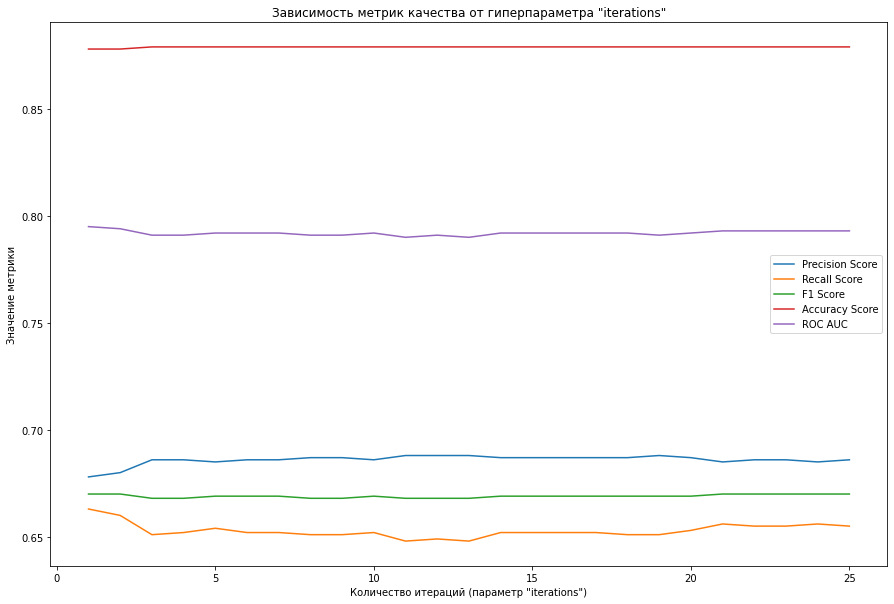

In [30]:
'''plt.figure(figsize=[15, 10])
plt.plot(catboost_scores['Precision Score'], label=catboost_scores.columns[0])
plt.plot(catboost_scores['Recall Score'], label=catboost_scores.columns[1])
plt.plot(catboost_scores['F1 Score'], label=catboost_scores.columns[2])
plt.plot(catboost_scores['Accuracy Score'], label=catboost_scores.columns[3])
plt.plot(catboost_scores['ROC AUC'], label=catboost_scores.columns[4])
plt.xlabel('Количество итераций (параметр "iterations")')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик качества от гиперпараметра "iterations"')
plt.legend()
plt.show()'''
visualize_it(catboost_scores)

In [31]:
catboost_scores[catboost_scores['ROC AUC'] == catboost_scores['ROC AUC'].max()]

,Precision Score,Recall Score,F1 Score,Accuracy Score,ROC AUC
1,0.678,0.663,0.67,0.878,0.795


## Набор данных "Вторая итерация"

In [32]:
X, y, X_val, y_val = load_datasets('2_X.csv', '2_y.csv', '2_X_val.csv', '2_y_val.csv')

FileNotFoundError: [Errno 2] No such file or directory: '2_X.csv'